In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, wait
from dask import array as darr

from pathlib import Path

import hextraj

In [2]:
import cartopy
from matplotlib import pyplot as plt

## Parameters

We need to specify a few things for the trajectory data (location, chunks).

We also need to specify the hex projectoin. We choose a central position well withing the NWE shelf region (3W, 54.5N) and a hex size (radius) of 10 km

In [3]:
# parameters

data_path = "../../output_data/010_lagrangian_experiment.zarr/"
_chunks_traj = 20_000
_chunks_obs = -1

chunks_traj = 20_000
chunks_obs = -1

# ~ center of NWE Shelf dataset
lon_origin = -3.0
lat_origin = 54.5

hex_size_meters = 10_000  # radius of hexes

max_land_allowed = 0

## Dask

In [4]:
client = Client(n_workers=2, threads_per_worker=4, memory_limit=32e9, ip="0.0.0.0")
#client = Client(scheduler_file="../../scheduler.json")
client.restart()
client

/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42977 instead
  warnings.warn(
/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/utils.py:190: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to hostname: [Errno 101] Network is unreachable
  warnings.warn(
/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/utils.py:190: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to hostname: [Errno 101] Network is unreachable
  warnings.warn(
/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/utils.py:190: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to hostname: [Errno 101] Network is unreachable
  warnings.warn(
2024-09-11 11:42:10,070 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.6.113:42977/status,
Dashboard: http://10.0.6.113:42977/status,Workers: 2
Total threads: 8,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://10.0.6.113:45367,Workers: 2
Dashboard: http://10.0.6.113:42977/status,Total threads: 8
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://10.0.6.113:39073,Total threads: 4
Dashboard: http://10.0.6.113:39107/status,Memory: 29.80 GiB
Nanny: tcp://10.0.6.113:37169,


In [5]:
ds = xr.open_zarr(data_path)
ds

<xarray.Dataset> Size: 920GB
Dimensions:      (year: 4, offset: 122, traj: 100000, obs: 673)
Coordinates:
  * offset       (offset) int64 976B 0 1 2 3 4 5 6 ... 116 117 118 119 120 121
Dimensions without coordinates: year, traj, obs
Data variables:
    land         (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lat          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lon          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    salinity     (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    temperature  (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    time         (year, offset, traj, obs) datetime64[ns] 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.3.1

In [6]:
print(ds.nbytes / 1e9, "GiB")

919.587200976 GiB


## Create the hex projection and label all positions

Labelling is done lazily (no labels actually computed until we really request values).

In [70]:
ds_subset = ds.isel(obs=0, offset=0, year = 1, drop=True).compute()
ds_subset = ds_subset[["lon", "lat"]].to_dataframe().dropna()

In [71]:
ds_subset2 = ds.isel(obs=0, offset=1, year = 1, drop=True).compute()
ds_subset2 = ds_subset2[["lon", "lat"]].to_dataframe().dropna()

In [72]:
ds_subset3 = ds.isel(obs=0, offset=4, year = 1, drop=True).compute()
ds_subset3 = ds_subset3[["lon", "lat"]].to_dataframe().dropna()

In [73]:
ds_subset = ds_subset.iloc[::3]
ds_subset2 = ds_subset2.iloc[::3]
ds_subset3 = ds_subset3.iloc[::3]

<Axes: xlabel='lon', ylabel='lat'>

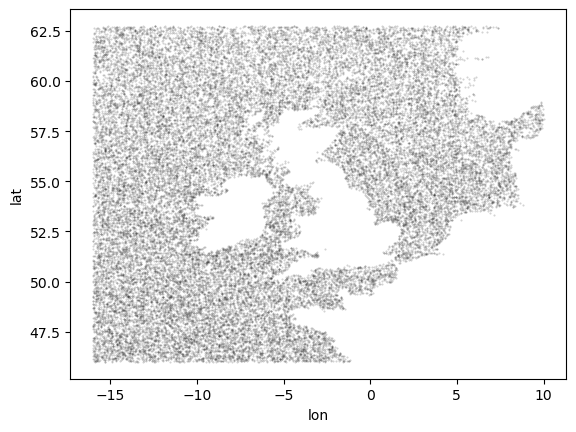

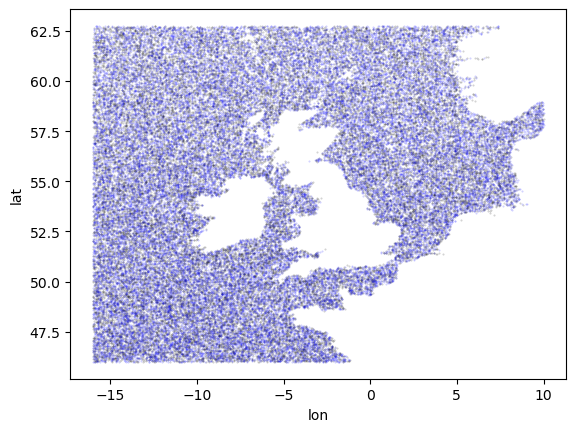

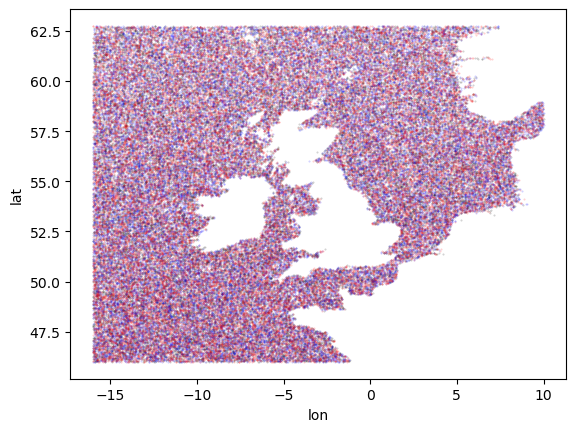

In [83]:
ax = ds_subset.plot.scatter(x="lon", y="lat", s=0.2, color="black", alpha=0.2)

ax2 = ds_subset.plot.scatter(x="lon", y="lat", s=0.2, color="black", alpha=0.2)
ds_subset2.plot.scatter(x="lon", y="lat", s=0.2, color="blue", alpha=0.2, ax=ax2)

ax3 = ds_subset.plot.scatter(x="lon", y="lat", s=0.2, color="black", alpha=0.2)
ds_subset2.plot.scatter(x="lon", y="lat", s=0.2, color="blue", alpha=0.2, ax=ax3)
ds_subset3.plot.scatter(x="lon", y="lat", s=0.2, color="red", alpha=0.2, ax=ax3)

### Old data

In [12]:
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, wait
from dask import array as darr

from pathlib import Path

import hextraj

In [13]:
import cartopy
from matplotlib import pyplot as plt

## Parameters

We need to specify a few things for the trajectory data (location, chunks).

We also need to specify the hex projectoin. We choose a central position well withing the NWE shelf region (3W, 54.5N) and a hex size (radius) of 10 km

In [14]:
# parameters

data_path = "../../output_data/010_lagrangian_experiment/"
_chunks_traj = 20_000
_chunks_obs = -1

chunks_traj = 20_000
chunks_obs = -1

# ~ center of NWE Shelf dataset
lon_origin = -3.0
lat_origin = 54.5

hex_size_meters = 10_000  # radius of hexes

max_land_allowed = 0

## Open the trajectory data

In [15]:
data_files_old = {y: sorted(
              f for f in Path(data_path).glob(f"*{y:4d}-05-15*.nc")
              if "seed-000012345" in f.name
              ) 
              for y in [2019, 2020, 2021, 2022]
}
print(data_files_old[2019][0])
print(len(data_files_old[2019]))
print(len(data_files_old[2020]))
print(len(data_files_old[2021]))
print(len(data_files_old[2022]))
print(data_files_old[2019][-1])

../../output_data/010_lagrangian_experiment/north-sea_oysters_start-ref-2019-05-15T00:00:00_start-offset-000_RT-0028_N-000100000_seed-000012345.nc
122
122
122
73
../../output_data/010_lagrangian_experiment/north-sea_oysters_start-ref-2019-05-15T00:00:00_start-offset-121_RT-0028_N-000100000_seed-000012345.nc


In [16]:
from tqdm import tqdm

In [17]:
data_files_valid_old = {}
for y in data_files_old.keys():
    _valid_files_old = []
    for f in tqdm(data_files_old[y]):
        try:
            _ = xr.open_dataset(f)
            _valid_files_old.append(f)
        except:
            pass
    data_files_valid_old[y] = _valid_files_old

100%|██████████| 73/73 [00:08<00:00,  9.06it/s]


In [18]:
data_files_old = data_files_valid_old

In [19]:
ds_old = {
    y: xr.open_mfdataset(
        data_files_old[y],
        chunks={"traj": _chunks_traj, "obs": _chunks_obs},
        combine="nested",
        concat_dim="offset",
        # not sure what's wrong here, but we cannot write
        # zarr store in parallel if we decode:
        decode_cf=False,
    )
    for y in data_files_old.keys()
}
for y in ds_old.keys():
    ds_old[y] = ds_old[y].assign_coords(offset=("offset", list(range(ds_old[y].dims["offset"]))))
    
ds_old = xr.concat(ds_old.values(), dim="year")

display(ds_old)
print(ds_old.nbytes / 1e9, "GiB")

/tmp/ipykernel_303328/2801865898.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds_old[y] = ds_old[y].assign_coords(offset=("offset", list(range(ds_old[y].dims["offset"]))))


<xarray.Dataset> Size: 1TB
Dimensions:      (year: 4, offset: 122, traj: 100000, obs: 673)
Coordinates:
  * offset       (offset) int64 976B 0 1 2 3 4 5 6 ... 116 117 118 119 120 121
Dimensions without coordinates: year, traj, obs
Data variables:
    time         (year, offset, traj, obs) float64 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    trajectory   (year, offset, traj, obs) float64 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lon          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lat          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    z            (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    temperature  (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    salinity     (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    land         (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

1313.696000976 GiB


In [65]:
ds_subset_old = ds_old.isel(obs=0, offset=0, year = 1, drop=True).compute()
ds_subset_old = ds_subset_old[["lon", "lat"]].to_dataframe().dropna()

In [66]:
ds_subset_old2 = ds_old.isel(obs=0, offset=1, year = 1, drop=True).compute()
ds_subset_old2 = ds_subset_old2[["lon", "lat"]].to_dataframe().dropna()

In [67]:
ds_subset_old3 = ds_old.isel(obs=0, offset=4, year = 1, drop=True).compute()
ds_subset_old3 = ds_subset_old3[["lon", "lat"]].to_dataframe().dropna()

In [68]:
ds_subset_old = ds_subset_old.iloc[::3]
ds_subset_old2 = ds_subset_old2.iloc[::3]
ds_subset_old3 = ds_subset_old3.iloc[::3]

<Axes: xlabel='lon', ylabel='lat'>

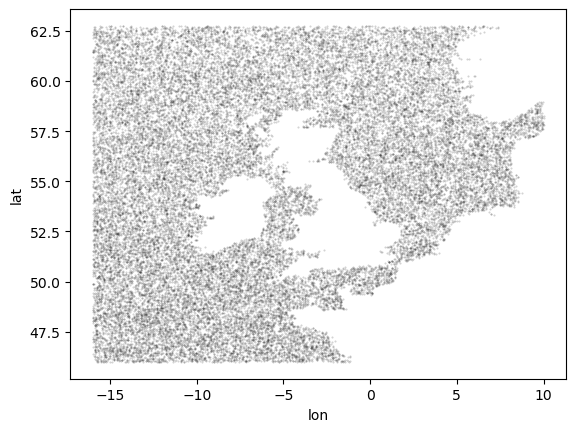

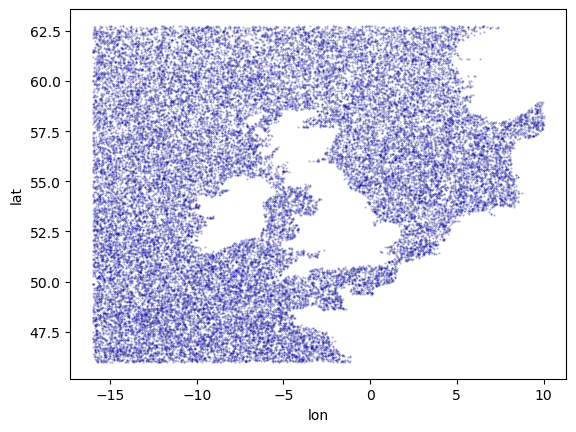

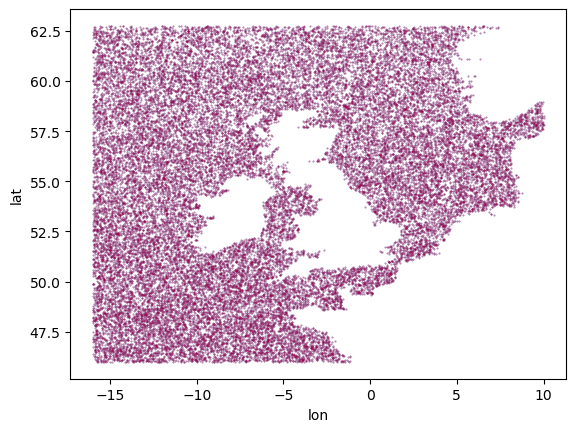

In [82]:
ax = ds_subset_old.plot.scatter(x="lon", y="lat", s=0.2, color="black", alpha=0.2)

ax2 = ds_subset_old.plot.scatter(x="lon", y="lat", s=0.2, color="black", alpha=0.2)
ds_subset_old2.plot.scatter(x="lon", y="lat", s=0.2, color="blue", alpha=0.2, ax=ax2)

ax3 = ds_subset_old.plot.scatter(x="lon", y="lat", s=0.2, color="black", alpha=0.2)
ds_subset_old2.plot.scatter(x="lon", y="lat", s=0.2, color="blue", alpha=0.2, ax=ax3)
ds_subset_old3.plot.scatter(x="lon", y="lat", s=0.2, color="red", alpha=0.2, ax=ax3)